In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%matplotlib widget

In [2]:
def convert_datetime(time_pts: pd.core.series.Series) -> np.array:
    return np.array(time_pts, dtype='datetime64[m]')

def cap_temp_data(df: pd.DataFrame, temp_cap):
    df.iloc[:, 2:] = df.iloc[:, 2:].clip(upper=temp_cap)
    return df

In [3]:
filepath = r"../Data/Dataset of weighing station temperature measurements.csv"

df = pd.read_csv(filepath, sep=';')

# Update le dataframe
capping_temp = 50
df = cap_temp_data(df, capping_temp)

In [4]:
xdata_lbl = 'Time'
ydata_lbl = 'Outdoor temperature [deg. C]'

# Un-curated Data
Les fonctions de cette section utilisent tout le data, même si certains capteur sont clairement non-fonctionnel

<Figure size 640x480 with 0 Axes>

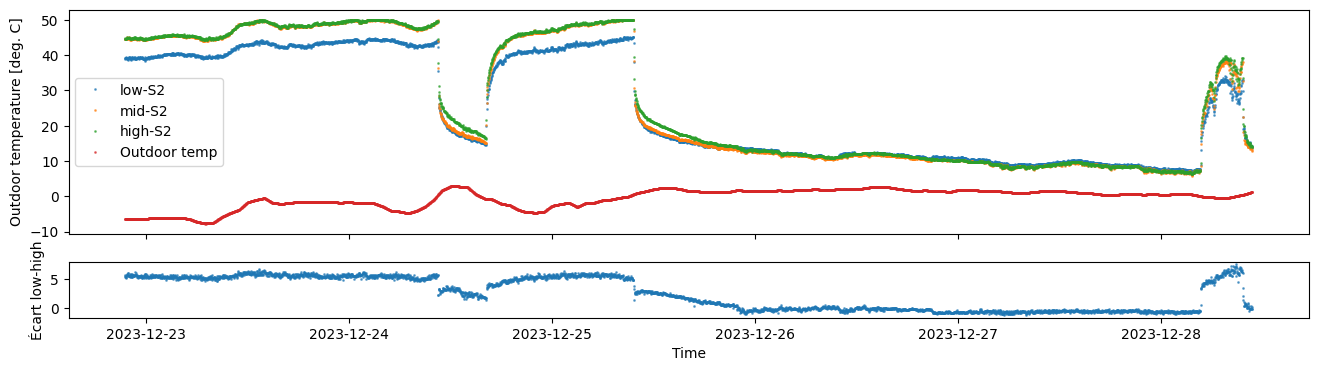

In [5]:
# On veut compute l'écart moyen et/ou médian entre low mid et high pour chaque cellule
P1 = [1, 2, 3, 4, 5]
P2 = [5, 6, 7, 8, 9]
P3 = [9, 10, 11, 12, 13]
P4 = [13, 14, 15, 16, 17, 18, 19]
P5 = [19, 20, 21, 22, 23]
P6 = [23, 24, 25, 26, 27, 28, 29]
all = [i+1 for i in range(29)]

def df_filter_fct(
        id_list=[i+1 for i in range(29)], 
        heights="lmh",
        df = df
        ):
    """
    Prend le dataframe au complet, et sort un nouveau df contenant uniquement les capteur spécifié
    On peut spécifier le id du capteur (1 à 29) avec une liste de int
    On peut spécifier low, mid ou high avec un str (s'il contient L et/ou M et/ou H)
    """

    # reject ids above 29
    id_list = sorted([i for i in id_list if i < 30])

    # initialise lists
    corrected_id_low, corrected_id_mid, corrected_id_high = [], [], []
    if "l" in heights or "L" in heights:
        corrected_id_low  = [i + 2 for i in id_list]
    if "m" in heights or "M" in heights:
        corrected_id_mid  = [i + 29 + 2 for i in id_list]
    if "h" in heights or "H" in heights:
        corrected_id_high = [i + 2*29 + 2 for i in id_list]

    # Filter df
    return df.iloc[:,[*corrected_id_low, *corrected_id_mid, *corrected_id_high]]
sensors = [2]
def lmh_stats(P):
    #get filtered dataframe
    df_low = df_filter_fct(P, heights='L')
    df_mid = df_filter_fct(P, heights='m')
    df_high = df_filter_fct(P, heights='h')

    # compute la différence  moyenne
    for i, id in enumerate(df_low.columns[:]):
        ecart = df_high.iloc[:,i] - df_low.iloc[:, i]
        print(f"{str(id)[12:]}: Mean = {ecart.mean():.2f}, Med = {ecart.median():.2f}, Std = {ecart.std():.2f}")
    return

def nicer_sensor_plot(sensors, s_idx=0, e_idx=len(df["Time"]), save_fig=False):
    """
    Prend une liste de sensor, et plot le low, mid, high et la différence low-high
    On peut spécifier des indices de début et de fin si on veut
    """
    df_low = df_filter_fct(sensors, heights='L')
    df_mid = df_filter_fct(sensors, heights='m')
    df_high = df_filter_fct(sensors, heights='h')
    for i, id in enumerate(df_low.columns[:]):
        plt.clf()
        fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 4),
                         gridspec_kw={'height_ratios': [4, 1]})
        ax0 = axes[0]
        ax1 = axes[1]
        # Plot le low, mid et high
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df_low.iloc[s_idx:e_idx, i], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="low-"+str(id)[12:])
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df_mid.iloc[s_idx:e_idx, i], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="mid-"+str(id)[12:])
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df_high.iloc[s_idx:e_idx, i], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="high-"+str(id)[12:])
        # Plot le outdoor temp
        ax0.plot(convert_datetime(df["Time"][s_idx:e_idx]), df.iloc[s_idx:e_idx, 1], marker='o', markersize= 1, alpha=0.6, linestyle = '', label="Outdoor temp")

        ax0.set_ylabel(ydata_lbl)
        ax0.legend()

        diff = df_high.iloc[s_idx:e_idx, i] - df_low.iloc[s_idx:e_idx, i]
        ax1.plot(convert_datetime(df["Time"][s_idx:e_idx]), diff, marker='o', markersize= 1, alpha=0.6, linestyle = '', label="low-"+str(id)[12:])
        ax1.set_xlabel(xdata_lbl)
        ax1.set_ylabel("Écart low-high")
        plt.show()
        if s_idx == 0 and e_idx == len(df["Time"]) and save_fig:
            fig.savefig(f'../fig/{str(id)[12:]}_hml_diff.png', dpi=600, bbox_inches='tight')
        elif save_fig:
            fig.savefig(f'../fig/{str(id)[12:]}_hml_diff_{s_idx}-{e_idx}.png', dpi=600, bbox_inches='tight')
    return
nicer_sensor_plot([2], 1000, 5000)

# Curating the Dataset
### Liste des capteur qui marchent
* P1 : [2, 3, 4] 
* P2 : [6, 7]
* P3 : [10, 11]
* P4 : [14, 16, 17, 19] (LOW et High seulement)
* P5 : [21, 22(LH)]
* P6 : [23(last 1/4), 26(first 3/4), 29(first 2/3)]

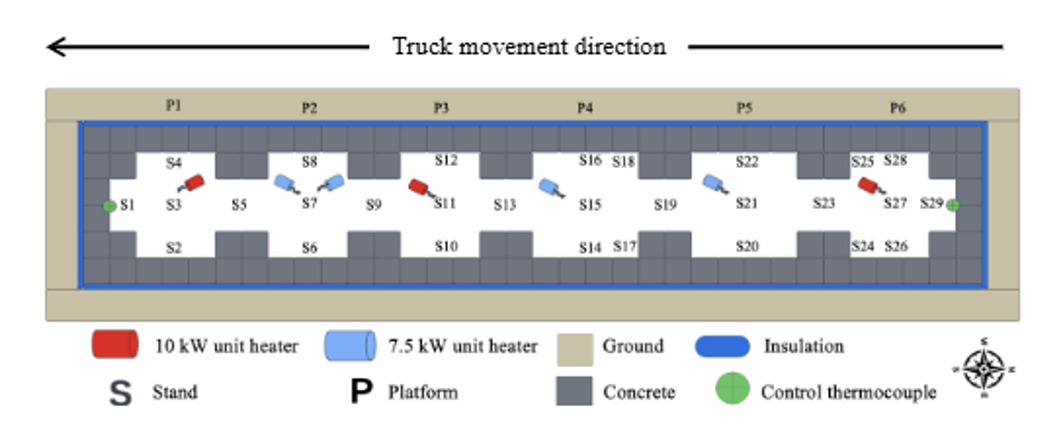

In [ ]:
# Fct qui donne juste les portions de data qu'on veut
def gen_clean_df(
        data_selection:dict,
        df
        ):
    # Initialiser le nouveau df
    result = df.iloc[:, [0]].copy()

    for id, (heights, (start, end)) in data_selection.items():

        heights = heights.lower()

        for h in 'lmh':
            if h in heights:
                if h == 'l':
                    col_index = id + 2
                elif h == 'm':
                    col_index = id + 29 + 2
                elif h == 'h':
                    col_index = id + 2*29 + 2

                # Initialisée colonne à NaN
                col = pd.Series([np.nan]*len(df), index=df.index)
                # range spécifié
                col.iloc[start:end] = df.iloc[start:end, col_index]
                col.name = df.columns[col_index]
                # Ajouter au résultat
                result[col.name] = col

    return result

full_range = (0, len(df["Time"])) # Tuple (start_idx, end_idx)
default = ('lmh', full_range) # Low mid high et tout le data
# Le data qui est beau
clean_data = {
    # P1
    2 : default,
    3 : default,
    4 : default,
    # P2
    6 : default,
    7 : default,
    # P3
    10 : default,
    11 : default,
    # P4
    14 : ('lh', full_range),
    16 : ('lh', full_range),
    17 : ('lh', full_range),
    19 : ('lh', full_range),
    # P5
    21 : default,
    22 : ('lh', full_range),
    # P6
    23 : ('lmh', ( int(3/4 * len(df["Time"])), len(df["Time"]))),
    26 : ('lmh', (0, int(3/4 * len(df["Time"])) ) ),
    26 : ('lmh', (0, int(2/3 * len(df["Time"])) ) ),
}

clean_dataset = gen_clean_df(clean_data, df)
clean_dataset

# Test dataset
test_data = {
    # P1
    2 : ('lmh', (0, 15000))
    }
test_dataset = gen_clean_df(test_data, df)

# Curated Dataset
Les fonctions qui suivent utiliser les données qui sont belles et représentative 

In [ ]:
# Plotter le beau data not done
def plot_curated_dataset(c_df):
    return

# Analyse statistique sur le data not done
def stat_analysis(c_df):
    return

Analysons spécifiquement la différence de comportement dans **P6** **avant** *vs* **après** le fonctionnement de l'aérotherme

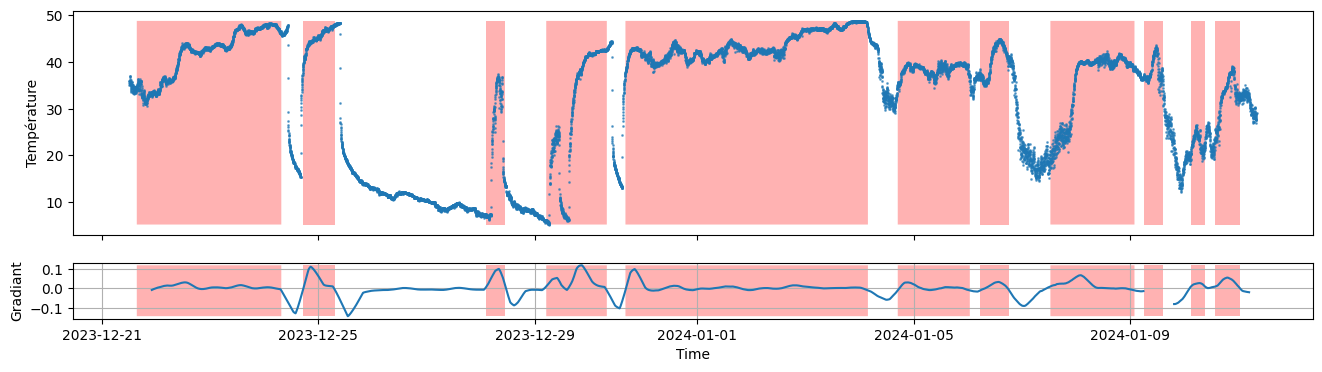

,Time,mean_temp_S2,mean_smooth_S2,grad_S2,is_heating_S2
0,2023-12-21 12:10,35.873646,NaN,NaN,False
1,2023-12-21 12:12,36.007529,NaN,NaN,False
2,2023-12-21 12:14,34.980528,NaN,NaN,False
3,2023-12-21 12:16,35.547295,NaN,NaN,False
4,2023-12-21 12:18,36.367144,NaN,NaN,False
...,...,...,...,...,...
54043,2024-03-05 13:36,NaN,NaN,NaN,False
54044,2024-03-05 13:38,NaN,NaN,NaN,False
54045,2024-03-05 13:40,NaN,NaN,NaN,False
54046,2024-03-05 13:42,NaN,NaN,NaN,False


In [122]:
def detect_heating(df, sensors=None, window_size=200, seuil=0.01, plot=False):

    result_df = pd.DataFrame({'Time': df['Time']})

    # On itère sur chaque id de sensor
    for id in sensors:

        # Init des df vides
        df_low = pd.Series([np.nan]*len(df), index=df.index)
        df_mid = pd.Series([np.nan]*len(df), index=df.index)
        df_high = pd.Series([np.nan]*len(df), index=df.index)

        acc = 0
        # Try de get tous les températures
        try:
            df_low = df[f"T[degC]-Low-S{id}"]
        except:
            acc += 1
            pass
        try:
            df_mid = df[f"T[degC]-Mid-S{id}"]
        except:
            acc += 1
            pass
        try:
            df_high = df[f"T[degC]-Top-S{id}"]
        except:
            acc += 1
            pass
        # Si aucun des sensor est dans la DF, on passe au prochain id
        if acc == 3:
            continue

        # Prend le mean et on smooth avec moving avg
        mean_temp = pd.concat([df_low, df_mid, df_high], axis=1).mean(axis=1)
        mean_smooth = mean_temp.rolling(window=window_size, center=True).mean()

        # Prend le gardiant, qu'on smooth avec un moving avg
        grad = mean_smooth.diff()
        grad = grad.rolling(window=window_size).mean()

        # Fait une colonne de bool
        is_heating = (grad > seuil).fillna(False)
        is_not_heating = (grad < -seuil).fillna(False)
        is_below_avg_temp = (mean_temp > mean_temp.mean()).fillna(False)

        # Logique pour isoler les moment où on est pomal certain que ça chauffe
        is_heating = (is_heating | is_below_avg_temp) & ~is_not_heating

        # Rolling window bool
        proportion_true = is_heating.rolling(window=window_size,center=True).median()
        seuil_proportion = 0.2 
        is_heating = (proportion_true > seuil_proportion).fillna(False)

        # Filte les niaiserie qui dure pas longtemps secondes
        is_heating = ~filter_short_events(~is_heating)

        # Fait notre entry pour df et ajoute dans res
        new_entry = pd.DataFrame({
            f'mean_temp_S{id}': mean_temp,
            f'mean_smooth_S{id}': mean_smooth,
            f'grad_S{id}': grad,
            f'is_heating_S{id}': is_heating
        }, index=df.index) 

        result_df = pd.concat([result_df, new_entry], axis=1)

        if plot:
            heating_plot(convert_datetime(df["Time"]), mean_temp, mean_smooth, grad, is_heating)

    return result_df

def heating_plot(time, mean_temp, mean_smooth, grad, is_heating):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 4),
                         gridspec_kw={'height_ratios': [4, 1]})
    ax0 = axes[0]
    ax1 = axes[1]
        # Plot le low, mid et high
    ax0.plot(time, mean_temp, marker='o', markersize= 1, alpha=0.6, linestyle = '')
    #ax0.plot(time, mean_smooth, marker='o', markersize= 1, alpha=0.1, linestyle = '')
    ax0.set_ylabel("Température")
    #print(grad)

    ax1.plot(time, grad,  linestyle = '-')
    ax0.fill_between(convert_datetime(df["Time"]), mean_temp.min(), mean_temp.max(), where=is_heating, 
                     color='red', alpha=0.3, label='Chauffage ACTIF', edgecolor='none')
    ax1.fill_between(convert_datetime(df["Time"]), grad.min(), grad.max(), where=is_heating, 
                     color='red', alpha=0.3, label='Chauffage ACTIF', edgecolor='none')
    ax1.set_xlabel(xdata_lbl)
    ax1.set_ylabel("Gradiant")
    ax1.grid(True)
    plt.show()
    return

def filter_short_events(is_heating_series, min_length=50):
    """
    100% gemini ça
    Filtre les séquences consécutives de True dans une Série booléenne 
    qui sont plus courtes que 'min_length'.
    """
    
    # 1. Identifier les groupes consécutifs de True
    # 'is_heating_series.diff()' est Vrai au début de chaque nouveau groupe.
    # 'cumsum()' assigne un ID unique à chaque groupe.
    group_ids = (is_heating_series.diff() != 0).cumsum()

    # 2. Remplacer les valeurs False dans group_ids par NaN
    # Ceci isole les IDs des groupes où is_heating est Vrai.
    group_ids[~is_heating_series] = np.nan
    
    # 3. Calculer la taille de chaque groupe
    # On compte le nombre d'occurrences pour chaque ID de groupe.
    group_sizes = group_ids.groupby(group_ids).transform('count')

    # 4. Créer la Série filtrée
    # Le résultat est True seulement si l'événement est Vrai ET que sa taille est >= min_length.
    is_heating_filtered = (is_heating_series) & (group_sizes >= min_length)

    return is_heating_filtered.fillna(False)

test = detect_heating(test_dataset, all, plot=True)
test